In [1]:
# "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection
# Copyright (C) 2024 TU Dresden, Center for Information Services and High Performance Computing
#
# This file is part of the "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection.
#
# The "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
#
# The "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License along with "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection. If not, see <https://www.gnu.org/licenses/>.

In [2]:
import tarfile
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import subprocess
import numpy as np
from pylab import rcParams
from scipy.fftpack import fft2, fftfreq
from matplotlib.colors import ListedColormap



/tmp/ipykernel_153885/1575176308.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# loads the results
# stores: localities: a list of remote active, local, remote
#         state: the C-state. 0->POLL, 1->C1(E), 2->C6, 3->C8, 4->C10
#         frequencies: a list of frequencies that were tested
#         results. a dict of [locality][state][frequency]
tarball_path = '../test/out.perf.tar.gz'

# get local, cstates and frequencies

prog = re.compile('^out\.perf\.data\.([a-z_]+)_callee\.state(\d+)\.(\d+)\.(\d+)\.(\d+)$')

caller_prog= re.compile('^\s+cond_wait\s+\d+\s+\[\d+\]\s+(.+):\s+sched:sched_waking\:.+cpu=(\d+)$')

callee_prog= re.compile('^\s+\S+\s+\d+\s+\[\d+\]\s+(.+):\s+power:cpu_idle\:\s*state\=(\d+).+$')

frequencies=[]
localities={}
states=[]

file_names=[]

# Open the tar.gz file
tar = tarfile.open(tarball_path, 'r:gz')

# List all members (files and directories) in the tar.gz file
all_members = tar.getmembers()

# Iterate through each member and read its content line by line
for member in all_members:
    if member.isfile():
        file_name=member.name
        if file_name.startswith('out.perf.data'):
            file_names.append(file_name)

for f in file_names:
    result = prog.match(f)
    if result == None:
        continue
    if result.group(1) not in localities:
        localities[result.group(1)]=[result.group(4),result.group(5)]
    if int(result.group(3)) not in frequencies:
        frequencies.append(int(result.group(3)))
    if int(result.group(2)) not in states:
        states.append(int(result.group(2)))
frequencies=sorted(frequencies)
states=sorted(states)
#print (localities)

# get caller / callee
results={}
for locality in localities:
#    print(locality)
    results[locality]={}
    for state in states:
        results[locality][state]={}
        for frequency in sorted(frequencies):
#            print(locality,state,frequency)
            results[locality][state][frequency]={}
            # get the two files from file_names
            for s in ['caller','callee']:
                x = [f for f in file_names if f.startswith('out.perf.data.'+locality+'_'+s+'.state'+str(state)) and f.find('.'+str(frequency)+'.') != -1]
                results[locality][state][frequency][s]=x[0]
            # parse caller/callee
            caller_content=tar.extractfile(results[locality][state][frequency]['caller'])
            results[locality][state][frequency]['times']=[]
            callee_content=tar.extractfile(results[locality][state][frequency]['callee'])
            callee_times=[]
            callee_states=[]
            for callee_b_line in callee_content:
                callee_line=callee_b_line.decode('utf-8')
                result = callee_prog.match(callee_line)
                if result == None:
                    continue
                else:
                    callee_times.append(float(result.group(1)))
                    callee_states.append(int(result.group(2)))
            last_index=0
            for line_b in caller_content:
                line=line_b.decode('utf-8')
                # parse the line
                result = caller_prog.match(line)
                if result == None:
                    continue
                if int(result.group(2)) != int(localities[locality][1]):
                    continue
                caller_time=float(result.group(1))
                last_time=caller_time
                # find the next time in callee
                for callee_time_index in range(last_index,len(callee_times)):
                    callee_time=callee_times[callee_time_index]
                    if callee_time >= caller_time:
                        last_index=callee_time_index
                        results[locality][state][frequency]['times'].append((callee_time-caller_time)*1000000)
                        break
                results[locality][state][frequency]['times']

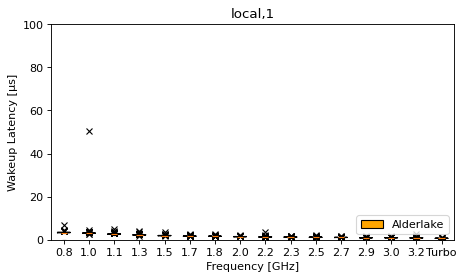

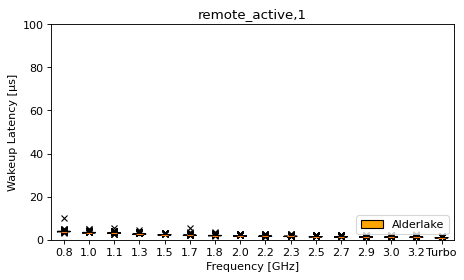

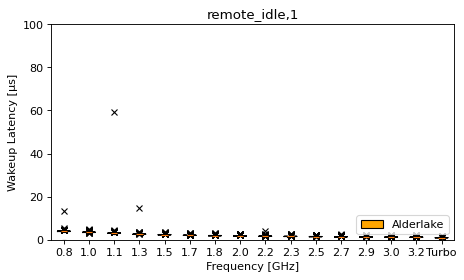

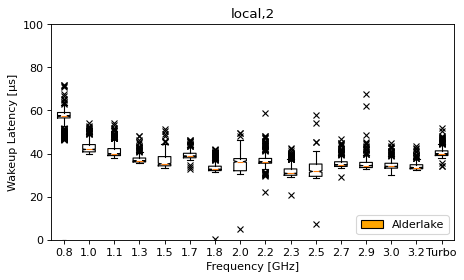

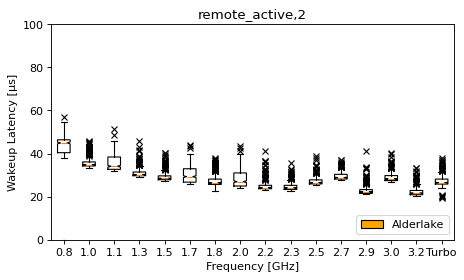

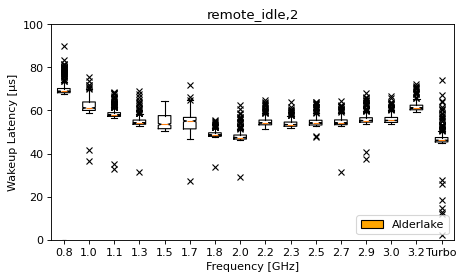

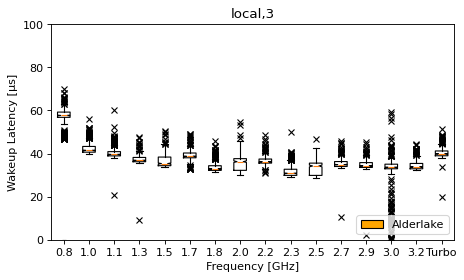

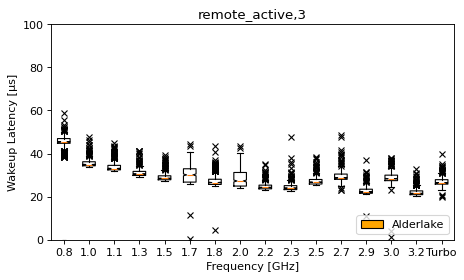

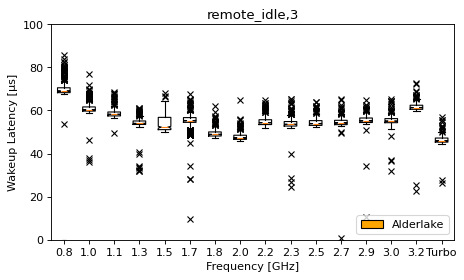

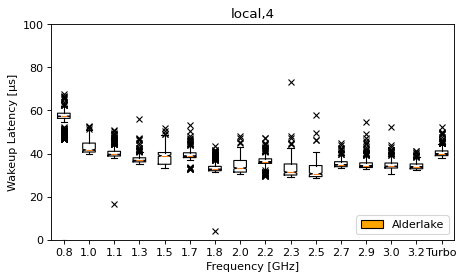

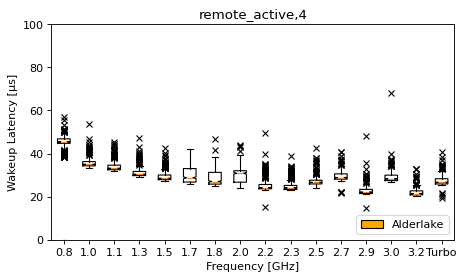

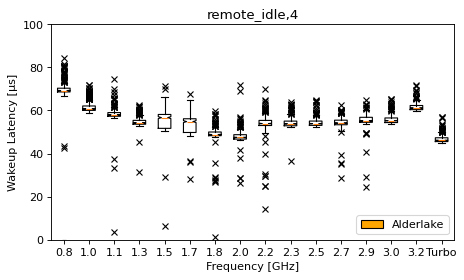

Done


In [4]:
#prints boxplots for each test (locality, state) over frequencies
from matplotlib.pyplot import figure
from matplotlib.patches import Patch

for state in sorted(states):
    for locality in sorted(localities):
        figure(num=None, figsize=(6.5, 3.5), dpi=80, facecolor='w', edgecolor='k')
        lists=[]
        xs=[]
        for frequency in sorted(frequencies):
            lists.append(results[locality][state][frequency]['times'])
            if ( frequency - 1000 ) % 100000 == 0:
                xs.append('Turbo')
            else:
                xs.append(frequency/1000000.0)
        plt.boxplot(lists,xs,sym='x') #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)

        lists=[]
        for frequency in sorted(frequencies):
            lists.append((0.0));
        c='#BBBBBB'
        plt.rcParams['pdf.fonttype'] = 42
        plt.boxplot(lists,xs,sym='x',patch_artist=True, boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c)) #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)

        legend_elements = [
                       Patch(facecolor='orange', edgecolor='black',
                             label='Alderlake')]

        plt.legend(handles=legend_elements, loc='lower right')
        plt.ylim([0,100])
        plt.xticks(range(1,len(xs)+1),xs)
        plt.xlabel("Frequency [GHz]")
        plt.ylabel(r'Wakeup Latency [µs]')
        plt.title(locality+','+str(state))
        plt.show()
   
print("Done")

In [5]:
def savefig(name, **kwargs):
    fn = "{}.pdf".format(name)
    pp = PdfPages(fn)
    pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)
    pp.close()
    print("saving and cropping ", fn)
    subprocess.run(["pdfcrop", fn, fn])

In [6]:
from pylab import rcParams
_frequency = "Frequency [GHz]"
_time = "Latency [μs]"
df_data = list()
print(frequencies)
for state in sorted(states):
    for locality in sorted(localities):
        for frequency in frequencies:
            for t in results[locality][state][frequency]['times']:
                df_data.append({
                    "state": state,
                    "locality": "P-core" if (locality == "local") else "E-core (active module)" if (locality == "remote_idle") else "E-core (idle module)",
                    "frequency": frequency,
                    _frequency: "Turbo" if (frequency % 100000 == 1000) else frequency / 1000000,
                    _time: t
                })

df = pd.DataFrame(df_data)
df = df[df[_time]<200]

[800000, 1000000, 1100000, 1300000, 1500000, 1700000, 1800000, 2000000, 2200000, 2300000, 2500000, 2700000, 2900000, 3000000, 3200000, 3201000]


P-core
E-core (idle module)
E-core (active module)


/tmp/ipykernel_153885/82099282.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle, color in zip(legend.legendHandles, palette):


saving and cropping  C6_onecolumn.pdf
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `C6_onecolumn.pdf'.


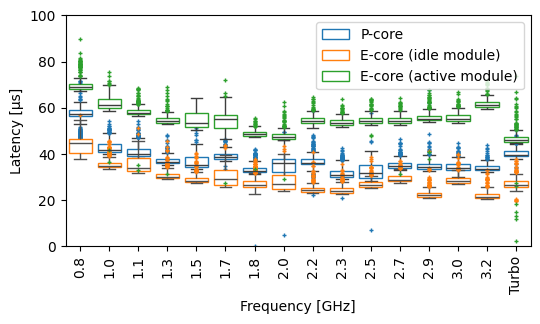

In [8]:
import matplotlib.patches as mpatches
from pylab import rcParams

rcParams['figure.figsize'] = 6, 3

sns.set_palette('tab10')
palette = sns.color_palette()

legend_labels = []

for i, locality in enumerate(df[df.state == 4]["locality"].unique()):
    print(locality)
    legend_labels.append(locality)
    df2=df[df.state == 2]
    df2=df2[df2.locality == locality]
    kwargs = {
        "flierprops": {
            "marker": "+",
            "markersize": 3,
            "markerfacecolor": "None",
            "markeredgecolor": palette[i]
            #"linestyle": "-"
        },
        "linewidth": 1.,
        "whis": 1.5,
    }
    sns.boxplot(
        data=df2,
        x=_frequency,
        y=_time,
        boxprops = { 'linewidth': 1, 'facecolor' : 'white', 'edgecolor': palette[i]},
    **kwargs
    )
legend_patches = [mpatches.Patch(edgecolor=palette[i], facecolor="white", label=label) for i, label in enumerate(legend_labels)]
legend = plt.legend(handles=legend_patches, loc='upper right')

# Set the line colors of the legend patches to match the boxplot lines
for handle, color in zip(legend.legendHandles, palette):
    handle.set_edgecolor(color)

plt.rcParams['pdf.fonttype'] = 42
plt.xticks(rotation=90)
plt.gca().set_ylim([0,100])
savefig("C6_onecolumn")